In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import warnings
warnings.filterwarnings('ignore')

In [3]:
# DATA PREPROCESSING
from data_preprocessing import getData
schema, number_of_buildings, number_of_actions, random_seed = getData(
    active_actions=['electrical_storage', 'dhw_storage'],
    number_of_buildings=2,
    number_of_days=30,
    root_path='./'
)
number_of_episodes = 200

Active buildings in the schema: 
Building_1
Building_2


Active observations in the schema: 
day_type
hour
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
outdoor_relative_humidity_predicted_6h
outdoor_relative_humidity_predicted_12h
outdoor_relative_humidity_predicted_24h
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
indoor_dry_bulb_temperature
indoor_relative_humidity
non_shiftable_load
solar_generation
dhw_storage_soc
electricity_pricing
cooling_device_cop
cooling_demand
dhw_demand
cooling_electricity_consumption
dhw_electricity_consumption
indoor_dry_bulb_temperature_delta


Active actions in the schema: 

In [3]:
from agents.CustomRBC import train_rbc
from rewardFunctions.rewardFunction3 import CustomRewardFunction

action_map = {i: 0.0 for i in range(1, 25)}

number_of_episodes = 2

rbc_results = train_rbc(
    schema=schema,
    action_map=action_map,
    episodes=number_of_episodes,
    reward_function=CustomRewardFunction
)

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipywidgets\widgets\widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


IntProgress(value=0, description='Simulating:', max=1438, style=ProgressStyle(bar_color='maroon'))

Number of episodes to train: 2
0.6586729
0.6586729437112808


0.61825424
0.6182542244593302


0.6051759
0.6051759272813797


0.67978936
0.6797893613576889


0.84119517
0.8411952182650566


0.79463756
0.7946375544582095


1.4867504
1.4867503736168146


1.3651757
1.3651756462123659


1.1985297
1.1985296860337258


1.2203578
1.2203578095544467


1.110231
1.1102310034135978


0.96860504
0.968605005970368


0.8789149
0.8789148852229118


0.99285924
0.9928592532873154


1.0209191
1.020919089205563


1.0234087
1.0234087083269567


1.0068603
1.0068603944447305


1.0386949
1.0386949346253747


1.0887346
1.0887346394360065


1.1060133
1.1060132476545514


1.0961142
1.0961141728542068


1.0928934
1.092893403509389


1.0886732
1.0886733159422874


1.0711179
1.0711179178953172


1.0506742
1.0506741639513235


1.031711
1.0317110457906016


1.0506437
1.0506436521453517


1.0697354
1.0697354643509305


1.0881897
1.0881897489229837


1.0651731
1.0651732125589926


1.0724473
1.072447263635695


1.038895

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.000000,0.000000,0.000000
annual_peak_average,NaN,NaN,1.000000
carbon_emissions_total,1.000000,1.000000,1.000000
cost_total,1.000000,1.000000,1.000000
daily_one_minus_load_factor_average,NaN,NaN,1.000000
daily_peak_average,NaN,NaN,1.000000
discomfort_delta_average,-3.275963,-1.738484,-2.507224
discomfort_delta_maximum,0.845596,1.151920,0.998758
discomfort_delta_minimum,-6.693027,-5.547022,-6.120025


In [31]:
from agents.DQN import train_dqn
from rewardFunctions.rewardFunction3 import CustomRewardFunction
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func


# from data_preprocessing import getData
schema, number_of_buildings, number_of_actions, random_seed = getData(
    active_actions=['electrical_storage', 'dhw_storage'],
    number_of_buildings=1,
    number_of_days=30,
    root_path='./'
)

dqn_kwargs = {
    # 'learning_starts': 50000,
    # 'learning_rate': 0.0001,
    # 'buffer_size': 50000,
    # 'batch_size': 128,
    # 'gamma': 0.99,
    # 'train_freq': (1, 'step'),
    # 'gradient_steps': 1,
    'target_update_interval': 3600,
    # 'exploration_fraction': 0.2,
    # 'policy_kwargs': dict(
    #     net_arch=[512, 512, 512],
    # )
}

number_of_episodes = 1000

dqn_results = train_dqn(
    agent_kwargs=dqn_kwargs,
    schema=schema,
    action_bins={'electrical_storage': 9, 'dhw_storage': 9},
    episodes=number_of_episodes,
    reward_function=CustomRewardFunction,
    random_seed=random_seed
)

Active buildings in the schema: 
Building_1


Active observations in the schema: 
day_type
hour
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
outdoor_relative_humidity_predicted_6h
outdoor_relative_humidity_predicted_12h
outdoor_relative_humidity_predicted_24h
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
indoor_dry_bulb_temperature
indoor_relative_humidity
non_shiftable_load
solar_generation
dhw_storage_soc
electricity_pricing
cooling_device_cop
cooling_demand
dhw_demand
cooling_electricity_consumption
dhw_electricity_consumption
indoor_dry_bulb_temperature_delta


Active actions in the schema: 
dhw_storag

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class 
has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import 
create_comm`.
  self.comm = Comm(**args)

Output()

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Number of episodes to train: 1000


C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


name,Building_1,District
cost_function,,
annual_normalized_unserved_energy_total,0.0000,0.0000
annual_peak_average,NaN,1.0049
carbon_emissions_total,0.9739,0.9739
cost_total,1.0093,1.0093
daily_one_minus_load_factor_average,NaN,0.9926
daily_peak_average,NaN,0.9876
discomfort_delta_average,-3.2760,-3.2760
discomfort_delta_maximum,0.8456,0.8456
discomfort_delta_minimum,-6.6930,-6.6930


In [7]:
dqn_results['model'].save('saved/DQN/dqn_2024-04-15-1')

In [37]:
from agents.A2C import train_a2c
from rewardFunctions.consumptionDeviationRewardFunction import CustomRewardFunction

a2c_kwargs = {
    'use_sde': True,
    'vf_coef': 0.1,
    # 'use_rms_prop': False,
    'learning_rate': 0.02,
    'ent_coef': 0.01,
    'gamma': 0.999,
    # 'normalize_advantage': True,
    'max_grad_norm': 5,
    'n_steps': 24,
    'policy_kwargs': dict(
        # net_arch=[512, 512],
        # 'use_sde'=True,
        # squash_output=True,
        # ortho_init=False,
        # lr_schedule=0.02
    )
}

number_of_episodes = 1

a2c_results = train_a2c(
    agent_kwargs=a2c_kwargs,
    schema=schema,
    episodes=number_of_episodes,
    reward_function=CustomRewardFunction,
    random_seed=random_seed
)

Output()

Number of episodes to train: 200


name,Building_1,District
cost_function,,
annual_normalized_unserved_energy_total,0.0000,0.0000
annual_peak_average,NaN,1.0000
carbon_emissions_total,1.0000,1.0000
cost_total,1.0000,1.0000
daily_one_minus_load_factor_average,NaN,1.0000
daily_peak_average,NaN,1.0000
discomfort_delta_average,-1.1230,-1.1230
discomfort_delta_maximum,0.8456,0.8456
discomfort_delta_minimum,-4.9301,-4.9301


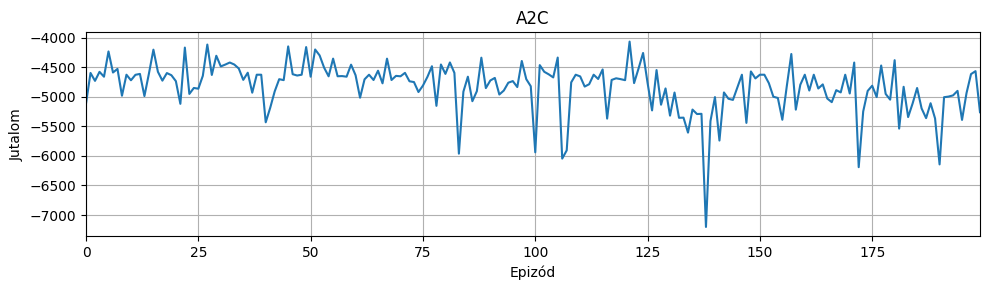

In [36]:
import numpy as np
%matplotlib inline

rewards = {
    # 'DQN': dqn_results['rewards'],
    # 'SAC': sac_results['rewards'],
    'A2C': a2c_results['rewards'],
    # 'DDPG': ddpg_callback.reward_history[:number_of_episodes],
    # 'TD3': td3_callback.reward_history[:number_of_episodes],
    # 'PPO': ppo_callback.reward_history[:number_of_episodes]
}

min_value = min(min(rewards[key]) for key in rewards)
max_value = max(max(rewards[key]) for key in rewards)

round_factor = 10 ** np.floor(np.log10(max(abs(min_value), abs(max_value))))
min_value = np.floor(min_value / round_factor) * round_factor
max_value = np.ceil(max_value / round_factor) * round_factor

fig, axs = plt.subplots(1, len(rewards), figsize=(10, 3), sharey=True)

# rbc_rewards = [episode_reward['sum'][0] for episode_reward in rbc_results['env'].episode_rewards]
for ax, (k, v) in zip(fig.axes, rewards.items()):
    # ax.plot(rbc_rewards, 'r--', label='RBC')
    ax = plot_rewards(ax, v, k)
    # ax.set_ylim(min_value, max_value)
    ax.set_xlim(0, number_of_episodes - 1)
    # ax.set_yscale(value='symlog')
    ax.grid()
    ax.set_xlabel('Epizód')
    ax.set_ylabel('Jutalom')
    
plt.tight_layout()
plt.show()

In [91]:
a2c_results['model'].save('saved/A2C/a2c_default')

In [29]:
from agents.DDPG import train_ddpg
from rewardFunctions.rewardFunction3 import CustomRewardFunction
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import numpy as np

action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(4), sigma=0.106399 * np.ones(4))

ddpg_kwargs = {
    # 'learning_rate': 0.001971,
    # 'batch_size': 317,
    # "gradient_steps": 8,
    # 'gamma': 0.999600,
    # 'train_freq': (22, 'step'),
    # 'tau': 0.000410,
    # 'action_noise': action_noise,
    # 'policy_kwargs': dict(
    #     # net_arch=[512, 512],
    #     # 'use_sde'=True,
    #     # squash_output=True,
    #     # ortho_init=False,
    #     # lr_schedule=0.02
    # )
}

number_of_episodes = 200

ddpg_results_cpu = train_ddpg(
    agent_kwargs=ddpg_kwargs,
    schema=schema,
    episodes=number_of_episodes,
    reward_function=CustomRewardFunction,
    random_seed=random_seed
)

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


TypeError: DDPG.__init__() got an unexpected keyword argument 'n_cpu_tf_sess'

In [28]:
print(ddpg_results["env"].episode_rewards[-2:])

[{'min': [-20.070240020751953], 'max': [-0.00022847912623547018], 'sum': [-542.6558227539062], 'mean': [-0.7547369003295898]}, {'min': [-20.444482803344727], 'max': [-0.0003328727325424552], 'sum': [-517.582763671875], 'mean': [-0.7198647856712341]}]


In [12]:
ddpg_results['model'].save('saved/DDPG/ddpg_2024-04-15-0')

In [14]:
from agents.SAC import train_sac
from rewardFunctions.rewardFunction3 import CustomRewardFunction
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import numpy as np
from typing import Callable
import flax.linen as nn
# import torch.nn as nn

n_actions = number_of_actions * number_of_buildings
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.020235 * np.ones(n_actions))

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

sac_kwargs = {
    'learning_rate': 0.001029,
    'gamma': 0.956859,
    'train_freq': (5, 'step'),
    'gradient_steps': 19,
    'action_noise': action_noise,
    "tau": 0.003616,
    'policy_delay': 9,
    "batch_size": 212,
    "use_sde": False,
    'policy_kwargs': dict(
        net_arch=[256, 256],
        activation_fn=nn.relu,
        n_critics=2
    )
}

number_of_episodes = 200

sac_results = train_sac(
    agent_kwargs=sac_kwargs,
    schema=schema,
    episodes=number_of_episodes,
    reward_function=CustomRewardFunction,
    random_seed=random_seed
)

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class 
has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import 
create_comm`.
  self.comm = Comm(**args)

Output()

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[2811895930   14179026]
Number of episodes to train: 200


C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/0)>

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=3/0)>

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/0)>

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/0)>

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/0)>

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/0)>

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/0)>

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/0)>

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/0)>

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Traced<ShapedArray(uint32[2])>with<DynamicJaxprTrace(level=1/0)>

C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag
es\Python310\site-packages\ipywidgets\widgets\widget_output.py:111: DeprecationWarning: Kernel._parent_header is 
deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.0000,0.0000,0.0000
annual_peak_average,NaN,NaN,0.8850
carbon_emissions_total,0.9968,1.0839,1.0404
cost_total,0.9791,1.0752,1.0271
daily_one_minus_load_factor_average,NaN,NaN,0.7923
daily_peak_average,NaN,NaN,0.6912
discomfort_delta_average,-3.2760,-1.7385,-2.5072
discomfort_delta_maximum,0.8456,1.1519,0.9988
discomfort_delta_minimum,-6.6930,-5.5470,-6.1200


In [23]:
sac_results['model'].save('saved/SAC/sac_2024-04-23')

In [24]:
sum(sac_results["rewards_ts"]) / 720

-0.44637078617261144

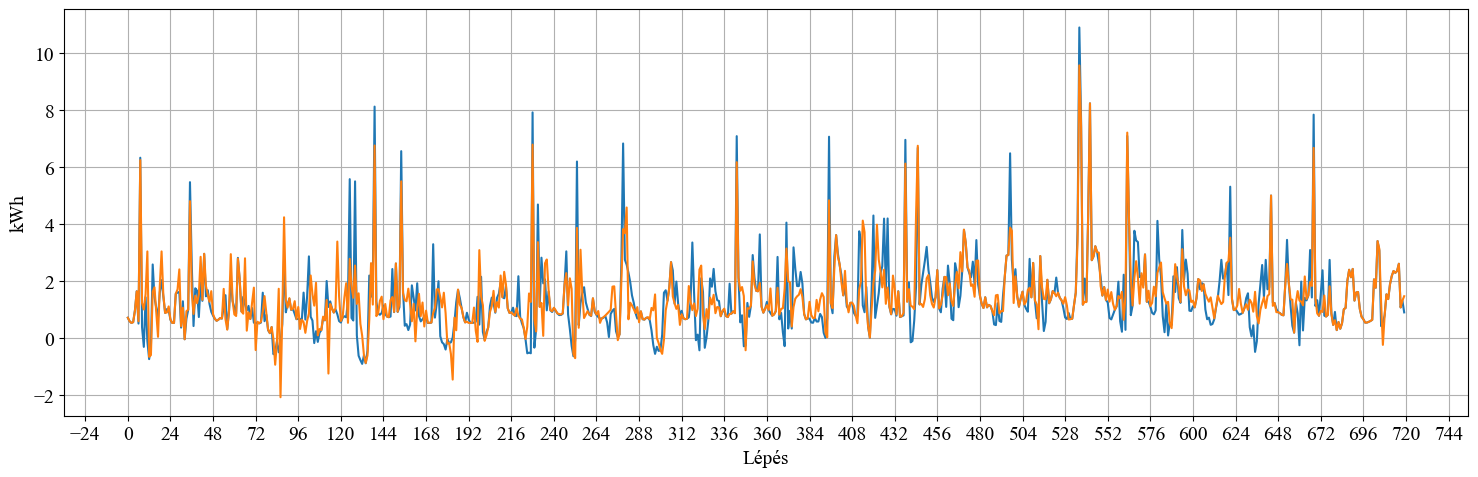

In [30]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

envs = {
    # 'RBC': rbc_results['env'],
    # 'DQN': dqn_results['env'],
    # 'SAC': sac_results['env'],
    # 'A2C': a2c_results['env'],
    'DDPG': ddpg_results['env'],
    # 'TD3': td3_env,
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption_without_storage
    x = range(len(y))
    ax.plot(x, y, label=k)

    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label=k)

# y = v.electrical_storage_electricity_consumption
# ax.plot(x, y, label='Battery')
# y = v.dhw_storage_electricity_consumption
# ax.plot(x, y, label='DHW storage')

# baseline = sac_results['env'].net_electricity_consumption_without_storage
# y_difference = [y - base for y, base in zip(v.net_electricity_consumption, baseline)]
# ax.plot(x, y_difference, label=k)

ax.set_xlabel('Lépés')
ax.set_ylabel('kWh')
# ax.set_xlim(120, 160)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.grid()
plt.tight_layout()

In [25]:
selected_env = sac_results["env"]

avg_decrease = np.mean([(x - y) for x, y in zip(selected_env.net_electricity_consumption_without_storage, selected_env.net_electricity_consumption) if ((x > 6) and x > y)])
avg_increase = np.mean([(y - x) for x, y in zip(selected_env.net_electricity_consumption_without_storage, selected_env.net_electricity_consumption) if ((x > 6) and x < y)])

successful_peak_timesteps = [i for i, (x, y) in enumerate(zip(selected_env.net_electricity_consumption_without_storage, selected_env.net_electricity_consumption)) if (x > 6) and x > y]
unsuccessful_peak_timesteps = [i for i, (x, y) in enumerate(zip(selected_env.net_electricity_consumption_without_storage, selected_env.net_electricity_consumption)) if (x > 6) and x < y]

print(f"Number of successful peak timesteps: {len(successful_peak_timesteps)}")
print(f"Number of unsuccessful peak timesteps: {len(unsuccessful_peak_timesteps)}")
print(f"Successful peak timesteps: {successful_peak_timesteps}")
print(f"Unsuccessful peak timesteps: {unsuccessful_peak_timesteps}")
print(f"Average decrease: {avg_decrease}")
print(f"Average increase: {avg_increase}")

Number of successful peak timesteps: 13
Number of unsuccessful peak timesteps: 3
Successful peak timesteps: [139, 154, 228, 279, 343, 395, 438, 445, 497, 536, 542, 563, 668]
Unsuccessful peak timesteps: [7, 253, 537]
Average decrease: 1.7202816422169025
Average increase: 0.6157131791114807


In [9]:
selected_env = sac_results

recharge_energy_dhw_model = [max(y, x) for x, y in zip(selected_env["env"].net_electricity_consumption, selected_env["env"].dhw_storage_electricity_consumption) if x < 0 and y < 0]
recharge_energy_battery_model = [max(y, x) for x, y in zip(selected_env["env"].net_electricity_consumption, selected_env["env"].electrical_storage_electricity_consumption) if x < 0 and y < 0]

recharge_energy_timesteps = [i for i, (x, y) in enumerate(zip(selected_env["env"].net_electricity_consumption, selected_env["env"].electrical_storage_electricity_consumption)) if x < 0 and y < 0]
offset_recharge_energy_timesteps = [i + 1 for i in recharge_energy_timesteps]
recharge_energy_rewards = [selected_env["rewards_ts"][i] for i in offset_recharge_energy_timesteps]

print(f"Number of recharge energy timesteps: {len(recharge_energy_timesteps)}")
print(f"Recharge energy timesteps: {recharge_energy_timesteps}")
print(f"Recharge energy dhw model: {sum(recharge_energy_dhw_model)}")
print(f"Recharge energy battery model: {sum(recharge_energy_battery_model)}")
print(f"Recharge energy dhw values: {recharge_energy_dhw_model}")
print(f"Recharge energy battery values: {recharge_energy_battery_model}")
print(f"Net consumption values: {[selected_env['env'].net_electricity_consumption[i] for i in recharge_energy_timesteps]}")
print(f"Recharge energy rewards: {recharge_energy_rewards}")
print(f"Recharge energy rewards: {np.mean(recharge_energy_rewards)}")
print(f"Model mean rewards: {np.mean(selected_env['rewards_ts'])}")

Number of recharge energy timesteps: 2
Recharge energy timesteps: [86, 87]
Recharge energy dhw model: -0.2971183657646179
Recharge energy battery model: -0.7641963511705399
Recharge energy dhw values: [-0.07205832004547119, -0.22506005]
Recharge energy battery values: [-0.23453046, -0.5296658873558044]
Net consumption values: [-0.36680999398231506, -0.5296658873558044]
Recharge energy rewards: [-0.061988334632874655, -0.002187966007691893]
Recharge energy rewards: -0.032088150320283275
Model mean rewards: -0.4314804384646984


In [27]:
selected_env = sac_results

last_timesteps_battery_soc = [b.electrical_storage.soc[-1] for b in selected_env["env"].buildings]
battery_capacities = [b.electrical_storage.capacity_history[0] for b in selected_env["env"].buildings]

last_timesteps_dhw_storage_soc = [b.dhw_storage.soc[-1] for b in selected_env["env"].buildings]
# dhw_storage_capacities = [b.dhw_storage.capacity_history[0] for b in selected_env["env"].buildings]

print(f"Last timesteps battery soc: {last_timesteps_battery_soc}")
print(f"Battery capacities: {battery_capacities}")
print(f"Last timesteps dhw storage soc: {last_timesteps_dhw_storage_soc}")
# print(f"DHW storage capacities: {dhw_storage_capacities}")

Last timesteps battery soc: [0.34554234, 0.19929235]
Battery capacities: [4.0, 4.0]
Last timesteps dhw storage soc: [0.89790034, 0.82502055]


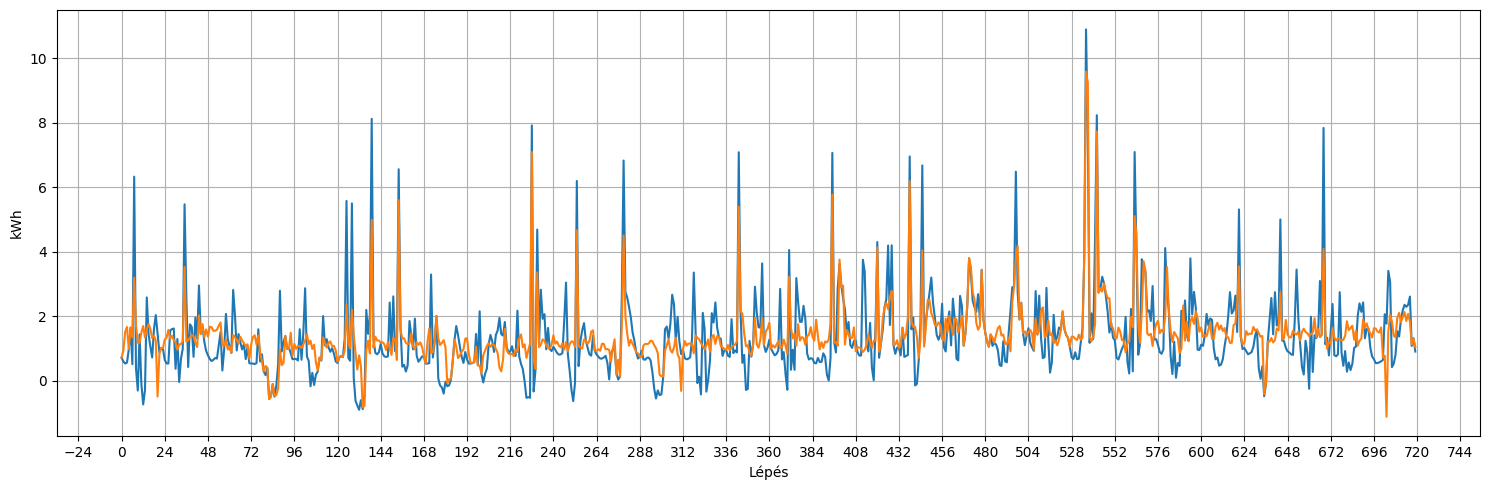

In [12]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

envs = {
    # 'RBC': rbc_results['env'],
    # 'DQN': dqn_results['env'],
    'SAC': sac_results['env'],
    # 'A2C': a2c_results['env'],
    # 'DDPG': ddpg_results['env'],
    # 'TD3': td3_env,
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption_without_storage
    x = range(len(y))
    ax.plot(x, y, label=k)

    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label=k)


ax.set_xlabel('Lépés')
ax.set_ylabel('kWh')
# ax.set_xlim(120, 160)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.grid()
plt.tight_layout()

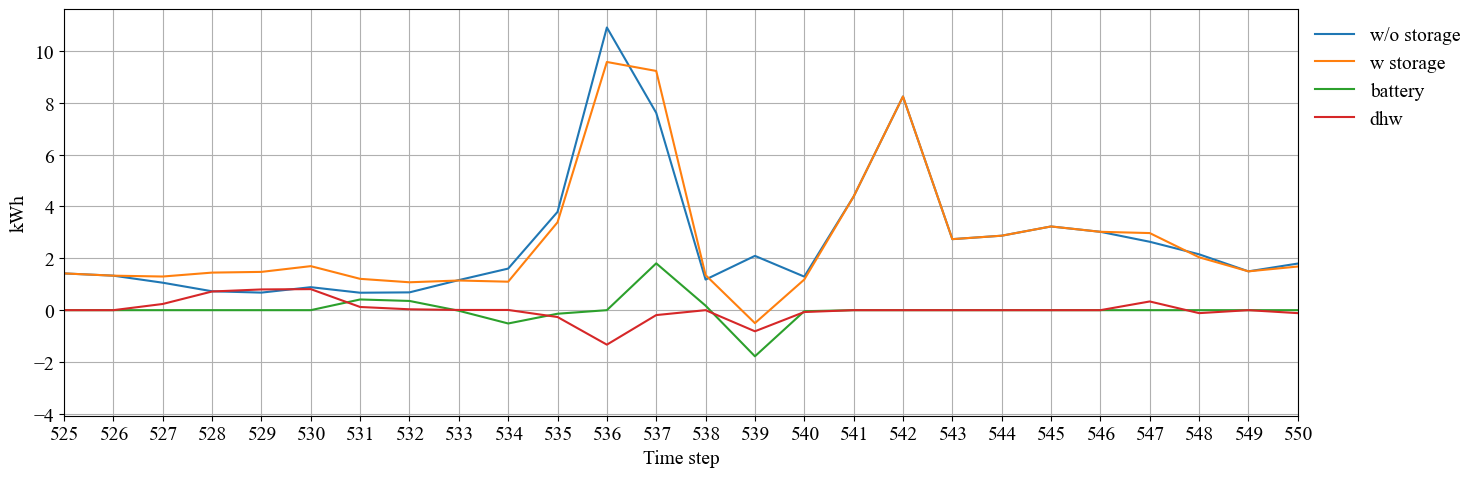

In [26]:
import matplotlib.ticker as ticker
%matplotlib inline

envs = {
    # 'RBC': rbc_results['env'],
    # 'DQN': dqn_results['env'],
    'SAC': sac_results['env'],
    # 'A2C': a2c_results['env'],
    # 'DDPG': ddpg_results['env'],
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption_without_storage
    x = range(len(y))
    ax.plot(x, y, label="w/o storage")
    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label="w storage")
    y = v.electrical_storage_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label="battery")
    y = v.dhw_storage_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label="dhw")

ax.set_xlabel('Time step')
ax.set_ylabel('kWh')
ax.set_xlim(525, 550)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
plt.grid()

plt.tight_layout()

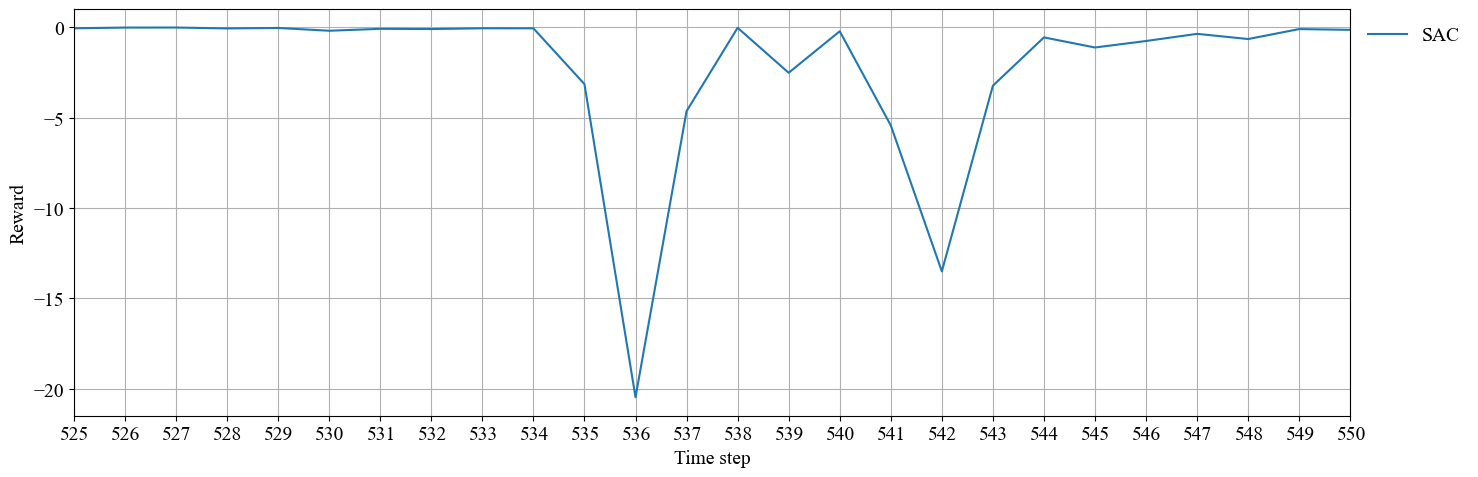

In [27]:
import matplotlib.ticker as ticker
%matplotlib inline

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

y = sac_results['rewards_ts']
x = np.arange(1, len(y) + 1)
ax.plot(x, y, label=k)

ax.set_xlabel('Time step')
ax.set_ylabel('Reward')
# ax.set_ylim(-50, 1)
# ax.set_xlim(24, 48)
ax.set_xlim(525, 550)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
plt.grid()

plt.tight_layout()

In [32]:
from typing import List
import matplotlib.pyplot as plt

def plot_rewards(ax: plt.Axes, rewards: List[float], title: str) -> plt.Axes:
    """Plots rewards over training episodes.

    Parameters
    ----------
    rewards: List[float]
        List of reward sum per episode.
    title: str
        Plot axes title

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    ax.plot(rewards)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(title)

    return ax

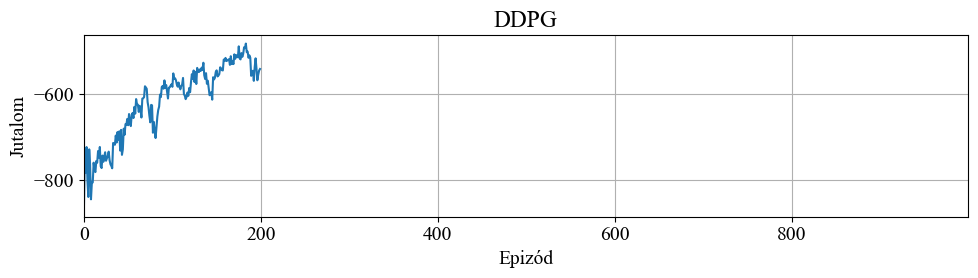

In [33]:
import numpy as np
import matplotlib.ticker as ticker
%matplotlib inline

plt.rcParams.update({'font.size': 14, 'font.family': 'Times New Roman'})

rewards = {
    # 'DQN': dqn_results['rewards'],
    # 'SAC': sac_results['rewards'],
    # 'A2C': a2c_results['rewards'],
    'DDPG': ddpg_results['rewards'],
    # 'TD3': td3_callback.reward_history[:number_of_episodes],
    # 'PPO': ddpg_results['rewards']
}

min_value = min(min(rewards[key]) for key in rewards)
max_value = max(max(rewards[key]) for key in rewards)

round_factor = 10 ** np.floor(np.log10(max(abs(min_value), abs(max_value))))
min_value = np.floor(min_value / round_factor) * round_factor
max_value = np.ceil(max_value / round_factor) * round_factor

fig, axs = plt.subplots(1, len(rewards), figsize=(10, 3), sharey=True)

# rbc_rewards = [episode_reward['sum'][0] for episode_reward in rbc_results['env'].episode_rewards]
for ax, (k, v) in zip(fig.axes, rewards.items()):
    # ax.plot(rbc_rewards, 'r--', label='RBC')
    ax = plot_rewards(ax, v, k)
    # ax.set_ylim(min_value, max_value)
    ax.set_xlim(0, number_of_episodes - 1)
    # ax.set_yscale(value='symlog')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
    ax.grid()
    ax.set_xlabel('Epizód')
    ax.set_ylabel('Jutalom')
    
plt.tight_layout()
plt.show()

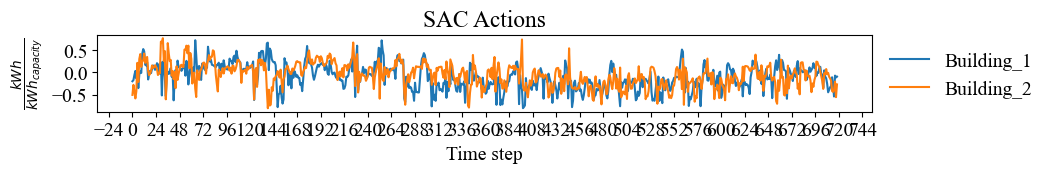

In [15]:
from typing import List
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
%matplotlib inline

def plot_actions(actions_list: List[List[float]], title: str) -> plt.Figure:
    """Plots action time series for different buildings

    Parameters
    ----------
    actions_list: List[List[float]]
        List of actions where each element with index, i,
        in list is a list of the actions for different buildings
        taken at time step i.
    title: str
        Plot axes title

    Returns
    -------
    fig: plt.Figure
        Figure with plotted axes

    """

    fig, ax = plt.subplots(1, 1, figsize=(10, 1))
    columns = [b.name for b in sac_results['env'].buildings]
    actions_list = [[inner[1], inner[3]] for inner in actions_list]
    plot_data = pd.DataFrame(actions_list, columns=columns)
    x = list(range(plot_data.shape[0]))

    for c in plot_data.columns:
        y = plot_data[c].tolist()
        ax.plot(x, y, label=c)

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_xlabel('Time step')
    ax.set_ylabel(r'$\frac{kWh}{kWh_{capacity}}$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_title(title)

    return fig

fig = plot_actions(sac_results['actions'], 'SAC Actions')
plt.show()

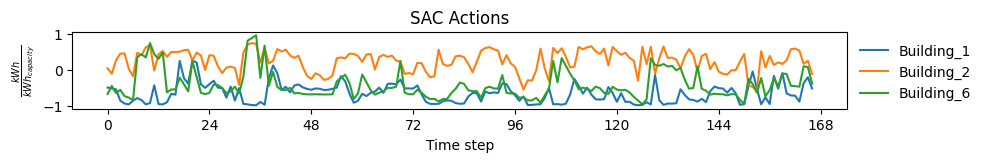

In [12]:
from typing import List
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
%matplotlib inline

def plot_actions(actions_list: List[List[float]], title: str) -> plt.Figure:
    """Plots action time series for different buildings

    Parameters
    ----------
    actions_list: List[List[float]]
        List of actions where each element with index, i,
        in list is a list of the actions for different buildings
        taken at time step i.
    title: str
        Plot axes title

    Returns
    -------
    fig: plt.Figure
        Figure with plotted axes

    """

    fig, ax = plt.subplots(1, 1, figsize=(10, 1))
    columns = [b.name for b in sac_results['env'].buildings]
    actions_list = [[inner[0], inner[2], inner[4]] for inner in actions_list]
    plot_data = pd.DataFrame(actions_list, columns=columns)
    x = list(range(plot_data.shape[0]))

    for c in plot_data.columns:
        y = plot_data[c].tolist()
        ax.plot(x, y, label=c)

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_xlabel('Time step')
    ax.set_ylabel(r'$\frac{kWh}{kWh_{capacity}}$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_title(title)

    return fig

fig = plot_actions(sac_results['actions'], 'SAC Actions')
plt.show()

In [34]:
# from stable_baselines3.sac import SAC
from sbx import SAC
import pickle
from rewardFunctions.rewardFunction3 import CustomRewardFunction

test_name = 'sac_2024-04-29-87'

with open("./saved/sac/" + test_name + "/" + test_name + ".pkl", "rb") as f:
    env = pickle.load(f)

model = SAC.load("./saved/sac/" + test_name + "/" + test_name + ".zip", env=env)

observations = env.reset()
actions_list = []
rewards_list = []

while not env.done:
    actions, _ = model.predict(observations, deterministic=True)
    observations, reward, _, _ = env.step(actions)
    actions_list.append(actions)
    rewards_list.append(reward)

kpis = env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.0000,-0.0000,-0.0000
annual_peak_average,NaN,NaN,0.7558
carbon_emissions_total,0.9957,1.0981,1.0469
cost_total,0.9837,1.0869,1.0353
daily_one_minus_load_factor_average,NaN,NaN,0.7393
daily_peak_average,NaN,NaN,0.6678
discomfort_delta_average,-3.2760,-1.7385,-2.5072
discomfort_delta_maximum,0.8456,1.1519,0.9988
discomfort_delta_minimum,-6.6930,-5.5470,-6.1200


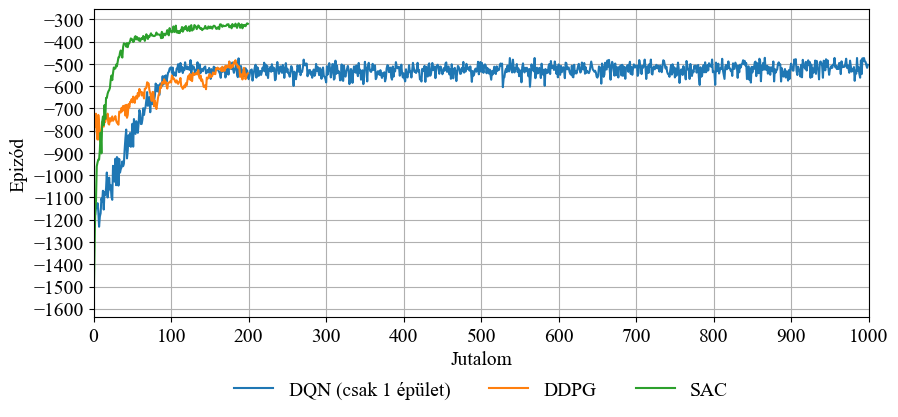

: 

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 14, 'font.family': 'Times New Roman'})

plt.figure(figsize=(10, 4))

plt.plot(dqn_results['rewards'], label="DQN (csak 1 épület)")
plt.plot(ddpg_results['rewards'], label="DDPG")
plt.plot([episode_reward["sum"] for episode_reward in env.episode_rewards][:200], label="SAC")

plt.ylabel("Epizód")
plt.xlabel("Jutalom")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), framealpha=0.0, fancybox=True, ncol=3)

plt.xlim(0, 1000)

plt.grid()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))

plt.show()